In [80]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
words = open('../names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [82]:
# build the vocab
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [105]:
# build the dataset
block_size = 3 # context length: how many chars we take to predict next one
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [106]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [174]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


Paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [19]:
# embedding table: Each character as 27 values in OHE -> 2 values
C = torch.randn((27, 2)).float()
C.shape

torch.Size([27, 2])

2 ways directly pick C[5] or matrix mul
F.one_hot(torch.tensor(5), num_classes=27).float() @ C == C[5]

In [40]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [41]:
W1 = torch.randn((6, 100))
B1 = torch.randn(100)
W1.shape, B1.shape

(torch.Size([6, 100]), torch.Size([100]))

In [43]:
# stack all character embeddings of a training example linearly
h = torch.tanh(emb.view(-1, 6) @ W1 + B1)
h.shape

torch.Size([32, 100])

In [44]:
W2 = torch.randn((100, 27))
B2 = torch.randn(27)
W2.shape, B2.shape

(torch.Size([100, 27]), torch.Size([27]))

In [46]:
logits = h @ W2 + B2
logits.shape

torch.Size([32, 27])

In [51]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [53]:
prob[0].sum()

tensor(1.0000)

In [56]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.5720)

In [175]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [220]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [221]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [222]:
for p in parameters:
  p.requires_grad = True

In [223]:
# learning rate search space
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [236]:
lri = []
lossi = []
stepi = []

for i in range(10000):

    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    # lr = 0.1
    # decay
    lr = 0.1 if i < 1000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

1.9444868564605713


When using minibatch, gradient direction is not reliable, there will be jitter

To find correct, first hit/try to find a range

Training, dev, test splits
80, 10, 10

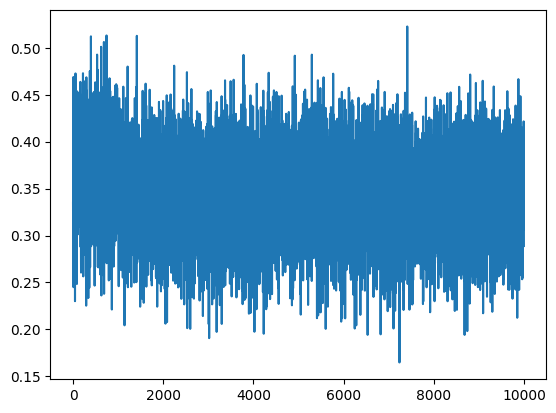

In [237]:
plt.plot(stepi, lossi)

In [238]:
# evaluate on dev set

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2289, grad_fn=<NllLossBackward0>)

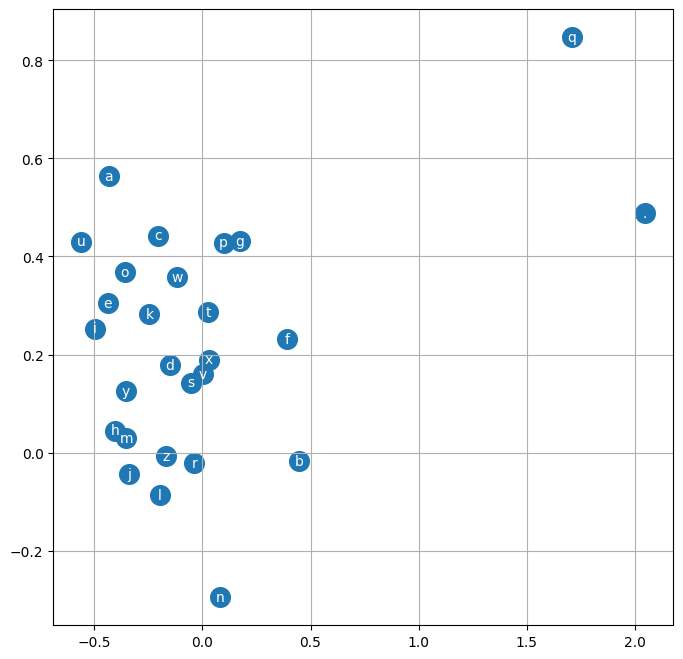

In [232]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [239]:
# evaluate on test set

emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.2307, grad_fn=<NllLossBackward0>)

In [243]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) # converts to prob distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))
    

carmah.
amelle.
khkinleige.
tyrencessa.
jazhuel.
den.
rhe.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
porriessan.
suline.
livebi.
watthoniearyxix.
kaen.
dura.
med.
ezi.
